In [199]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [200]:
# %%
def load_dataset(material, base_path="./Data/"):

    in_file1 = f"{base_path}{material}/train/B_Field.csv"
    in_file4 = f"{base_path}{material}/train/H_Field.csv"

    data_B = np.genfromtxt(in_file1, delimiter=',')  # N x 1024
    data_H = np.genfromtxt(in_file4, delimiter=',')  # N x 1024  # *250317新增

    return data_B, data_H


In [201]:
material = "CH467160"
# 想要下採樣到的點數
target_points = 512
data_B, data_H = load_dataset(material)

np.random.seed(9898)

# 假設各資料第一維代表樣本數
num_samples = data_B.shape[0]
# 產生一個隨機索引
random_index = np.random.randint(0, num_samples)

# 取出隨機選取的一筆資料
sample_B = data_B[random_index, :]  # B_Field, shape: (1024,)
sample_H = data_H[random_index, :]  # H_Field, shape: (1024,)

In [ ]:
def adaptive_downsample_indices(signal, target_points):

    # 計算離散差分與其絕對值
    diff_signal = np.diff(signal)
    abs_diff = np.abs(diff_signal)

    # 計算累積分佈函數 (CDF)，若信號幾乎無變化則採均勻取樣
    cdf = np.cumsum(abs_diff)
    if cdf[-1] == 0:
        indices = np.linspace(0, len(signal) - 1, target_points, dtype=int)
        return indices
    cdf = cdf / cdf[-1]

    # 在 [0, 1] 區間等間距取出 target_points 個數值，並取得對應的原始資料索引
    desired_vals = np.linspace(0, 1, target_points)
    indices = np.searchsorted(cdf, desired_vals)

    # 確保索引不超出範圍且最後一點被選到
    indices[indices >= len(signal)] = len(signal) - 1
    if indices[-1] != len(signal) - 1:
        indices[-1] = len(signal) - 1

    # 若平坦區段產生重複索引，這裡可保留唯一值（依需求調整）
    indices = np.unique(indices)
    return indices


In [ ]:
new_data_H = []
new_data_B = []

# # 以 H 信號計算下採樣索引，再將同一索引應用到 B 與 H 上
# for i in range(sample_H.shape[0]):
#     idx = adaptive_downsample_indices(sample_H[i, :], target_points)
#     new_data_H.append(sample_H[i, idx])
#     new_data_B.append(sample_B[i, idx])

# 取得對應索引
idx = adaptive_downsample_indices(sample_H, target_points)

# 用同一索引下採樣 H 與 B
downsampled_H = sample_H[idx]
downsampled_B = sample_B[idx]

# # 移除各列平均值（保持原始處理方式）
# new_data_H = new_data_H - np.mean(new_data_H, axis=1, keepdims=True)
# new_data_B = new_data_B - np.mean(new_data_B, axis=1, keepdims=True)

seq_length = target_points
cols = range(0, 8192, int(8192 / seq_length))  #range(start, stop, step)
downsampled_conv_B = data_B[random_index, cols]
downsampled_conv_H = data_H[random_index, cols]


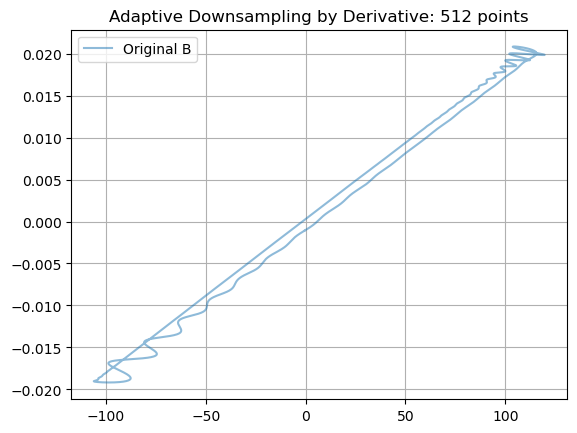

In [204]:
# 繪圖比較
# plt.figure(figsize=(10, 5))
plt.plot(sample_H, sample_B, label='Original B', alpha=0.5)
# plt.plot(downsampled_H,
#          downsampled_B,
#          marker='s',
#          markersize=1,
#          label='Adaptive Downsampled B',
#          linewidth=1)

# plt.plot(downsampled_conv_H,
#          downsampled_conv_B,
#          marker='s',
#          markersize=1,
#          label='Original Downsampled B',
#          linewidth=1,
#          alpha=0.7)

plt.legend()
plt.title(f'Adaptive Downsampling by Derivative: {target_points} points')
plt.grid(True)
plt.savefig(f"{target_points} points.svg", format="svg")
plt.show()
